/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


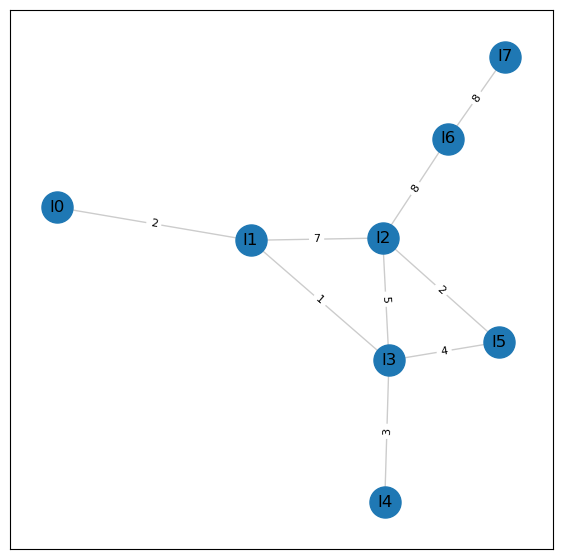

In [1]:
import graphviz
from unified_planning.shortcuts import *
import itertools
from unified_planning.engines import PlanGenerationResultStatus
from unified_planning.plot import plot_sequential_plan

# Create the graph with python environment

import matplotlib.pyplot as plt
import networkx as nx

G=nx.Graph()
#nodes
NLOC = 8 
nodes = ['l%s' % i for i in range(NLOC)]
G.add_nodes_from(nodes)
#edges with weight
weighted_edges = [ (nodes[0],nodes[1], 2), 
                   (nodes[1],nodes[2], 7),
                   (nodes[1],nodes[3], 1),
                   (nodes[2],nodes[3], 5), 
                   (nodes[3],nodes[4], 3),
                   (nodes[3],nodes[5], 4), 
                   (nodes[5],nodes[2], 2),
                   (nodes[2],nodes[6], 8), 
                   (nodes[6],nodes[7], 8), ]
G.add_weighted_edges_from(weighted_edges)

# Show the graph
plt.figure(figsize=(7, 7))
#pos = nx.kamada_kawai_layout(G, scale=1)
pos = nx.fruchterman_reingold_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos)

# Adding edge labels
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)

plt.show()

In [2]:
# Declaring types
Location = UserType("Location")
Package = UserType("Package")
Robot = UserType("Robot")

# Creating problem ‘variables’
robot_at = Fluent("robot_at", BoolType(), loc=Location, robot=Robot)
connected = Fluent('connected', BoolType(), l_from=Location, l_to=Location)
cost = Fluent("cost", IntType(), l_from=Location, l_to=Location)
robot_empty = Fluent('robot_empty', BoolType(), robot=Robot)
loc_empty = Fluent('loc_empty', BoolType(), loc=Location)
pack_at = Fluent('pack_at', BoolType(), loc=Location, p=Package)
robot_carry = Fluent("robot_carry", BoolType(), robot=Robot, p=Package)
pack_empty = Fluent("pack_empty", BoolType(), loc=Location)
#battery_level = Fluent("battery_level", RealType(), r=Robot)
battery_level = Fluent("battery_level", RealType())
# Define objects

# Programmatically create a map from location name to a new `Object` of type `Location`
locations = {str(l) : Object(str(l), Location) for l in G.nodes}

#packages
NPACK=2
packages = [Object('p%s' % i, Package) for i in range(NPACK)]

#robots
NROB=2
robots =  [Object('r%s' % i, Robot) for i in range(NROB)]

# Define actions

#robot move
move = DurativeAction('move', r=Robot, l_from=Location, l_to=Location)
l_from = move.parameter('l_from')
l_to = move.parameter('l_to')
r = move.parameter('r')
move.set_fixed_duration(cost(l_from,l_to))
move.add_condition(StartTiming(), connected(l_from,l_to))
move.add_condition(StartTiming(), robot_at(l_from, r))
move.add_condition(StartTiming(), loc_empty(l_to))
# move.add_condition(StartTiming(), Not(robot_busy(r)))
# move.add_condition(OpenTimeInterval(StartTiming(), EndTiming()), robot_busy(r))
# move.add_effect(StartTiming(), robot_busy(r), True)
# move.add_effect(EndTiming(), robot_busy(r), False)
move.add_effect(StartTiming(), loc_empty(l_to), False)
move.add_effect(StartTiming(), robot_at(l_from, r), False)
move.add_effect(EndTiming(), robot_at(l_to,r), True)
move.add_effect(EndTiming(), loc_empty(l_from), True)
move.add_decrease_continuous_effect(ClosedTimeInterval(StartTiming(), EndTiming()), 
                                    battery_level, 10*battery_level)
                                    #battery_level(r), 10*battery_level(r))


#load pack
load = DurativeAction('load', r=Robot, loc=Location, p=Package)
loc = load.parameter('loc')
p = load.parameter('p')
r = load.parameter('r')
load.set_fixed_duration(2)
load.add_condition(ClosedTimeInterval(StartTiming(), EndTiming()), robot_at(loc,r))
load.add_condition(StartTiming(), robot_empty(r))
load.add_condition(StartTiming(), pack_at(loc,p))
load.add_condition(StartTiming(), Not(pack_empty(loc)))
# load.add_condition(StartTiming(), Not(robot_busy(r)))
# load.add_condition(OpenTimeInterval(StartTiming(0.2), EndTiming()-0.2), robot_busy(r))
# load.add_effect(StartTiming(), robot_busy(r), True)
# load.add_effect(EndTiming(), robot_busy(r), False)
load.add_effect(StartTiming(), robot_empty(r), False)
load.add_effect(EndTiming(), pack_at(loc,p), False)
load.add_effect(EndTiming(), robot_carry(r,p), True)
load.add_effect(EndTiming(), pack_empty(loc), True)

#unload pack
unload = DurativeAction('unload', r=Robot, loc=Location, p=Package)
loc = unload.parameter('loc')
p = unload.parameter('p')
r = unload.parameter('r')
unload.set_fixed_duration(3)
unload.add_condition(ClosedTimeInterval(StartTiming(), EndTiming()), robot_at(loc, r))
unload.add_condition(StartTiming(), Not(robot_empty(r)))
unload.add_condition(StartTiming(), robot_carry(r,p))
unload.add_condition(StartTiming(), pack_empty(loc))
# unload.add_condition(StartTiming(), Not(robot_busy(r)))
# #unload.add_condition(OpenTimeInterval(StartTiming(), EndTiming()), robot_busy(r))
# unload.add_effect(StartTiming(), robot_busy(r), True)
# unload.add_effect(EndTiming(), robot_busy(r), False)
unload.add_effect(EndTiming(), robot_empty(r), True)
unload.add_effect(StartTiming(), robot_carry(r,p), False)
unload.add_effect(EndTiming(), pack_at(loc,p), True)
unload.add_effect(EndTiming(), pack_empty(loc), False)


# Create the problem
problem = Problem('robot')
problem.add_fluent(robot_at, default_initial_value=False)
problem.add_fluent(connected, default_initial_value=False)
problem.add_fluent(cost, default_initial_value=Int(0))
problem.add_fluent(robot_empty, default_initial_value=True)
problem.add_fluent(loc_empty, default_initial_value=True)
problem.add_fluent(pack_empty, default_initial_value=True)
problem.add_fluent(robot_carry, default_initial_value=False)
problem.add_fluent(battery_level, default_initial_value=100)
problem.add_fluent(pack_at, default_initial_value=False)
problem.add_action(move)
problem.add_action(load)
problem.add_action(unload)
problem.add_objects(locations.values())
problem.add_objects(packages)
problem.add_objects(robots)

#goal
for rob in robots:
    problem.add_goal(robot_empty(rob))

#problem.add_timed_goal(EndTiming(), pack_at(locations['l2'], packages[0]) )
#problem.add_goal(pack_at(locations['l2'], packages[0]) )
#problem.add_timed_goal(EndTiming(), pack_at(locations['l1'], packages[1]) )
problem.add_goal(robot_at(locations['l6'], robots[0]))
# problem.add_timed_goal(EndTiming(), robot_at(locations['l3'], robots[1]))

#metric
#m = MinimizeExpressionOnFinalState(total_move_cost())
# m =  MinimizeActionCosts({move: 10*cost(move.l_from, move.l_to), #I give a weight to load and unload in order to avoid
#                                           load: 1,             #stupid sequences such as leave the pack and pick it again.
#                                          unload: 1             #But I give much more weight to move costs since that is my primary goal.
#                           })
# problem.clear_quality_metrics()
# problem.add_quality_metric(m)


#set problem conditions

#robots initial condition
problem.set_initial_value(robot_at(locations['l6'], robots[0]), True)
problem.set_initial_value(loc_empty(locations['l6']), False)
problem.set_initial_value(robot_at(locations['l5'], robots[1]), True)
problem.set_initial_value(loc_empty(locations['l5']), False)

# Initializing the connectivity relations by iterating over the graph edges
for u, v, d in G.edges(data=True):
    problem.set_initial_value(connected(locations[str(u)], locations[str(v)]), True)
    problem.set_initial_value(connected(locations[str(v)], locations[str(u)]), True)
    problem.set_initial_value(cost(locations[str(u)], locations[str(v)]), int(d['weight']))
    problem.set_initial_value(cost(locations[str(v)], locations[str(u)]), int(d['weight']))

#packages position
problem.set_initial_value( pack_at(locations['l6'], packages[0]), True)
problem.set_initial_value(pack_empty(locations['l6']), False)
problem.set_initial_value( pack_at(locations['l3'], packages[1]), True)
problem.set_initial_value(pack_empty(locations['l3']), False)

#packages destination
# problem.set_initial_value( destination(packages[0]) , locations['l2'])
# problem.set_initial_value( destination(packages[1]) , locations['l7'])



In [3]:
print(problem)

problem name = robot

types = [Location, Robot, Package]

fluents = [
  bool robot_at[loc=Location, robot=Robot]
  bool connected[l_from=Location, l_to=Location]
  integer cost[l_from=Location, l_to=Location]
  bool robot_empty[robot=Robot]
  bool loc_empty[loc=Location]
  bool pack_empty[loc=Location]
  bool robot_carry[robot=Robot, p=Package]
  real battery_level
  bool pack_at[loc=Location, p=Package]
]

actions = [
  durative action move(Robot r, Location l_from, Location l_to) {
    duration = [cost(l_from, l_to), cost(l_from, l_to)]
    conditions = [
      [start]:
        connected(l_from, l_to)
        robot_at(l_from, r)
        loc_empty(l_to)
    ]
    effects = [
      start:
        loc_empty(l_to) := false:
        robot_at(l_from, r) := false:
      end:
        robot_at(l_to, r) := true:
        loc_empty(l_from) := true:
    ]
    continuous effects = [
      [start, end]:
       [battery_level :  d(battery_level)/dt = - (10 * battery_level)]
    ]
    simulated effec

In [4]:
print(problem.kind)

PROBLEM_CLASS: ['ACTION_BASED']
TIME: ['CONTINUOUS_TIME']
EXPRESSION_DURATION: ['INT_TYPE_DURATIONS', 'STATIC_FLUENTS_IN_DURATIONS']
CONDITIONS_KIND: ['NEGATIVE_CONDITIONS']
TYPING: ['FLAT_TYPING']


In [5]:
from unified_planning.io import PDDLWriter

writer = PDDLWriter(problem)
writer.write_domain("domain_mytest.pddl")
writer.write_problem("problem_mytest.pddl")